# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import re
import time

from random import randint
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [76]:
#загрузим данные
autos = pd.read_csv("/datasets/autos.csv")

In [77]:
#изучим данные 
display(autos.info())
autos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [78]:
autos['DateCrawled'].value_counts()

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-31 18:50:16    5
2016-04-02 22:54:55    5
                      ..
2016-03-15 22:46:24    1
2016-03-19 17:57:11    1
2016-04-01 21:50:22    1
2016-04-03 22:37:20    1
2016-03-22 16:45:25    1
Name: DateCrawled, Length: 271174, dtype: int64

In [79]:
autos['DateCrawled'].max()

'2016-04-07 14:36:58'

In [80]:
#приведем название колонок к змеиному регистру 
new_columns = []
for col in autos.columns:
    new_columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())
autos.columns = new_columns

In [81]:
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [82]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [83]:
show_rows(autos)

Уникальные значения столбца date_crawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2

In [84]:
# изучим данные на дубликаты и удалим их
autos.duplicated().sum()

4

In [85]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

In [86]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные содержат выбросы и ненужные столбцы

In [87]:
#Удалим ненужные столбцы
autos = autos.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<font color='4682B4'>Добавила</font>

In [88]:
autos.duplicated().sum()

45036

In [89]:
#удалим дубликаты
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

In [90]:
#проверим на наличие пропущенных значений
autos.isna().sum()

price                    0
vehicle_type         34559
registration_year        0
gearbox              17207
power                    0
model                18361
kilometer                0
fuel_type            30764
brand                    0
repaired             64558
dtype: int64

In [91]:
#Заполним пропуски uknown
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')
autos['model'] = autos['model'].fillna('unknown')
autos['fuel_type'] = autos['fuel_type'].fillna('unknown')

In [92]:
#в столбцах с бинарными значениями заполним данные на способом random  
#autos[['gearbox', 'repaired']] = autos[['gearbox', 'repaired']].fillna({
#    'gearbox': np.random.choice(autos['gearbox'].dropna()),
#    'repaired': np.random.choice(autos['repaired'].dropna())
#})

In [93]:
 autos['gearbox'].value_counts()

manual    232774
auto       59348
Name: gearbox, dtype: int64

In [94]:
 autos['repaired'].value_counts()

no     211328
yes     33443
Name: repaired, dtype: int64

In [95]:
# заполним пропуски значением "unknown"
autos['gearbox'] = autos['gearbox'].fillna('unknown')

In [96]:
# заполним пропуски значением "unknown"
autos['repaired'] = autos['repaired'].fillna('unknown')

In [97]:
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [98]:
autos.duplicated().sum()

0

In [99]:
autos.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [100]:
autos['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [101]:
autos = autos[(autos['registration_year'] >= 1960) & (autos['registration_year'] <= 2016)]

In [102]:
# найдем уникальные значения в столбце "год регистрации"
autos['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965, 1974,
       1979, 1978, 1972, 1968, 1977, 1961, 1960, 1966, 1975, 1963, 1964,
       1967, 1962])

Напишим функцию которая уберет выбросы из данных и нули

In [103]:
def drop_features(autos, features, q):
    for feature in features:
        autos = autos.loc[autos[feature] > 0, :]
        autos = autos.loc[autos[feature] > autos[feature].quantile(q), :]
        autos = autos.loc[autos[feature] < autos[feature].quantile(1-q), :]
    return autos

<AxesSubplot:>

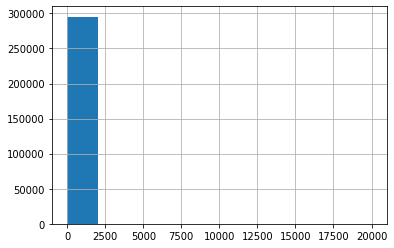

In [104]:
autos.power.hist()

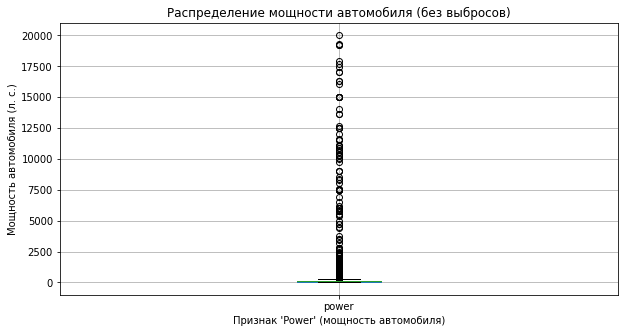

In [105]:
autos.boxplot(column='power', figsize=(10, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Мощность автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (без выбросов)')
plt.show()

In [106]:
autos['power'].value_counts()

0        32238
75       18440
150      12229
60       12222
90       10820
         ...  
1436         1
2461         1
923          1
10910        1
1653         1
Name: power, Length: 698, dtype: int64

In [107]:
#удалим аномалии - скорость больше 700
autos = autos[(autos['power'] <= 700)]

In [108]:
autos['power'].value_counts()

0      32238
75     18440
150    12229
60     12222
90     10820
       ...  
604        1
685        1
454        1
428        1
323        1
Name: power, Length: 458, dtype: int64

In [109]:
autos['power'] = autos['power'].replace(0, (autos['power'].median()))

In [110]:
autos['power'].value_counts()

105.0    40753
75.0     18440
150.0    12229
60.0     12222
90.0     10820
         ...  
356.0        1
339.0        1
678.0        1
541.0        1
572.0        1
Name: power, Length: 457, dtype: int64

In [111]:
autos.describe()

,price,registration_year,power,kilometer
count,295030.000000,295030.000000,295030.000000,295030.000000
mean,4548.142975,2002.575592,119.666054,127123.868759
std,4598.408875,6.911840,51.721343,38448.604376
min,0.000000,1960.000000,1.000000,5000.000000
25%,1100.000000,1999.000000,86.000000,125000.000000
50%,2850.000000,2003.000000,105.000000,150000.000000
75%,6590.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,700.000000,150000.000000


In [112]:
# проверим на аномалии значения столбца "цена"
autos['price'].value_counts()

0        8150
500      4443
1500     4247
1000     3600
1200     3559
         ... 
7234        1
13383       1
1857        1
5955        1
8188        1
Name: price, Length: 3693, dtype: int64

In [113]:
#удалим цену равную нулю
autos = autos[autos['price'] != 0]

In [114]:
autos['price'].value_counts()

500     4443
1500    4247
1000    3600
1200    3559
2500    3522
        ... 
2425       1
7540       1
887        1
4725       1
8188       1
Name: price, Length: 3692, dtype: int64

In [115]:
autos.corr(method='spearman')

,price,registration_year,power,kilometer
price,1.000000,0.620245,0.480616,-0.330906
registration_year,0.620245,1.000000,0.162587,-0.334998
power,0.480616,0.162587,1.000000,0.133598
kilometer,-0.330906,-0.334998,0.133598,1.000000


**Вывод**

В этом разделе мы произвели предобработку данных. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы date_crawled, registration_month, date_created, last_seen и number_of_pictures, заполнили пропуски в столбцах VehicleType, FuelType, Gearbox, Model, NotRepaired, избавились от аномалий. Удалили дубликаты и 
отфильтровали выбросы в столбцах price, registration_year, power 0.1% квантилем сверху и снизу.

## Обучение моделей

In [116]:
# Замена категориальных переменных на числовые
autos['vehicle_type'] = autos['vehicle_type'].astype('category').cat.codes
autos['gearbox'] = autos['gearbox'].astype('category').cat.codes
autos['model'] = autos['model'].astype('category').cat.codes
autos['fuel_type'] = autos['fuel_type'].astype('category').cat.codes
autos['brand'] = autos['brand'].astype('category').cat.codes
autos['repaired'] = autos['repaired'].astype('category').cat.codes

# Разделение данных на признаки и целевую переменную
X = autos.drop('price', axis=1)
y = autos['price']

# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [117]:
# Обучение модели LightGBM
start_time = time.time()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_val],
                      early_stopping_rounds=50,
                      verbose_eval=100)

end_time = time.time()
training_time_lgb = end_time - start_time

# Время обучения модели LightGBM
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgb = model_lgb.predict(X_val)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

# Оценка качества модели LightGBM на валидационной выборке
rmse_lgb = mean_squared_error(y_val, model_lgb.predict(X_val), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1718.88	valid_1's rmse: 1732.34
[200]	training's rmse: 1644.62	valid_1's rmse: 1682.81
[300]	training's rmse: 1602.33	valid_1's rmse: 1662.59
[400]	training's rmse: 1567.22	valid_1's rmse: 1649.4
[500]	training's rmse: 1539.8	valid_1's rmse: 1639.58
[600]	training's rmse: 1519.41	valid_1's rmse: 1634.46
[700]	training's rmse: 1500.2	valid_1's rmse: 1630.71
[800]	training's rmse: 1483.45	valid_1's rmse: 1626.6
[900]	training's rmse: 1467.33	valid_1's rmse: 1622.33
[1000]	training's rmse: 1454.28	valid_1's rmse: 1621.07
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1454.28	valid_1's rmse: 1621.07
Время обучения LightGBM: 98.77664685249329 секунд
Время пре

In [118]:
# Обучение модели CatBoostRegressor
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function='RMSE',
                                   random_state=42)

model_catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

end_time = time.time()
training_time_catboost = end_time - start_time

# Время обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)

# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost = model_catboost.predict(X_test)
end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

# Оценка качества модели CatBoostRegressor на валидационной выборке
rmse_catboost = mean_squared_error(y_val, model_catboost.predict(X_val), squared=False)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)

0:	learn: 4312.5401731	test: 4285.4415191	best: 4285.4415191 (0)	total: 80.9ms	remaining: 1m 20s
100:	learn: 1844.9117803	test: 1842.7204583	best: 1842.7204583 (100)	total: 2.62s	remaining: 23.3s
200:	learn: 1753.9642927	test: 1758.3809144	best: 1758.3809144 (200)	total: 5.28s	remaining: 21s
300:	learn: 1707.3852143	test: 1721.0577233	best: 1721.0577233 (300)	total: 7.92s	remaining: 18.4s
400:	learn: 1677.0643047	test: 1700.4321267	best: 1700.4321267 (400)	total: 10.6s	remaining: 15.8s
500:	learn: 1652.8958875	test: 1685.4003245	best: 1685.4003245 (500)	total: 13.1s	remaining: 13.1s
600:	learn: 1632.7484331	test: 1674.3925630	best: 1674.3925630 (600)	total: 15.7s	remaining: 10.4s
700:	learn: 1615.9994016	test: 1665.0517043	best: 1665.0517043 (700)	total: 18.3s	remaining: 7.8s
800:	learn: 1601.3569447	test: 1657.7518996	best: 1657.7518996 (800)	total: 20.7s	remaining: 5.15s
900:	learn: 1588.4555595	test: 1651.8629971	best: 1651.8629971 (900)	total: 23.3s	remaining: 2.56s
999:	learn: 157

In [119]:
start_time = time.time()

model_xgb = XGBRegressor(n_estimators=1000,
                         learning_rate=0.1,
                         max_depth=10,
                         random_state=12345,
                         subsample=0.8,
                         colsample_bytree=0.8)

model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=100)

end_time = time.time()
training_time_xgb = end_time - start_time

# Время обучения модели XGBRegressor
print("Время обучения XGBRegressor: %s секунд" % training_time_xgb)

# Время предсказания модели XGBRegressor
start_time = time.time()
y_pred_xgb = model_xgb.predict(X_test)
end_time = time.time()
prediction_time_xgb = end_time - start_time
print("Время предсказания XGBRegressor: %s секунд" % prediction_time_xgb)

# Оценка качества модели XGBRegressor на валидационной выборке
rmse_xgb = mean_squared_error(y_val, model_xgb.predict(X_val), squared=False)
print("RMSE XGBRegressor на валидационной выборке: %.2f" % rmse_xgb)

[0]	validation_0-rmse:5987.43408
[100]	validation_0-rmse:1616.03711
[200]	validation_0-rmse:1604.75293
[300]	validation_0-rmse:1605.68384
[309]	validation_0-rmse:1605.85339
Время обучения XGBRegressor: 308.6603751182556 секунд
Время предсказания XGBRegressor: 1.0791442394256592 секунд
RMSE XGBRegressor на валидационной выборке: 1603.64


In [144]:
# Заполнение пропущенных значений средними значениями для числовых признаков
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

# Заполнение пропущенных значений наиболее часто встречающимися значениями для категориальных признаков
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_val.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

In [145]:
start_time = time.time()

# Создаем объект модели линейной регрессии
model_lr = LinearRegression()

# Задаем сетку гиперпараметров для подбора
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, -1]
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(X_train, y_train)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lr = LinearRegression(**best_params)

# Обучаем модель на всем обучающем наборе данных
best_model_lr.fit(X_train, y_train)

end_time = time.time()
training_time_lr = end_time - start_time

# Предсказание цен на валидационной выборке
val_predictions_lr = best_model_lr.predict(X_val)

end_time = time.time()
prediction_time_lr = end_time - start_time

# Вычисление RMSE на валидационной выборке
rmse_lr = np.sqrt(mean_squared_error(y_val, val_predictions_lr))

print("Лучшие гиперпараметры модели LinearRegression: ", best_params)
print("RMSE LinearRegression на валидационной выборке: %.2f" % rmse_lr)

Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}
RMSE LinearRegression на валидационной выборке: 3023.18


**Вывод:**

В разделе Обучение моделей были выполнены следующие задачи:
Разделение на тренировочный, тестовый и валидационный наборы данных
Обучение моделей Linear Regression, LightGBM, CatBoostRegressor, XGBRegressor
Оценка качества модели, Определение время обучения и предсказание обучения

## Анализ моделей

In [146]:
# Создание таблички с результатами
results = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'CatBoostRegressor', 'XGBRegressor'],
                        'Training Time (sec)': [training_time_lr, training_time_lgb, training_time_catboost, training_time_xgb],
                        'Prediction Time (sec)': [prediction_time_lr, prediction_time_lgb, prediction_time_catboost, prediction_time_xgb],
                        'RMSE (Validation)': [rmse_lr, rmse_lgb, rmse_catboost, rmse_xgb]})

# Вывод результатов
results

,Model,Training Time (sec),Prediction Time (sec),RMSE (Validation)
0,Linear Regression,9.928910,9.932817,3023.182070
1,LightGBM,98.776647,4.291510,1621.072866
2,CatBoostRegressor,27.381358,0.059544,1647.009269
3,XGBRegressor,308.660375,1.079144,1603.636925


In [149]:
# Оценка качества модели XGBRegressor на тестовой выборке
rmse_test = mean_squared_error(y_val, model_xgb.predict(X_test), squared=False)
print("RMSE XGBRegressor на тестовой выборке: %.2f" % rmse_test)

RMSE XGBRegressor на тестовой выборке: 1603.64


**Вывод:**

В разделе Анализ моделей были выполнены следующие задачи:.

Выведена таблица сравнения метрик для сравнения моделей;
Проанализированы время обучения, время предсказания и качество моделей;
Выбрана лучшая модель, и проверено её качество на тестовой выборке.

Лучшая модель градиентного бустинга XGBRegressor тестовой выборке имеет значение метрики оценки качества RMSE =  1603.64